### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 22nd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
import time

# MRS Load in the data
data = np.load('../../../homeworks/hw_data/hw6_data_1.npy')

In [1]:
plt.scatter(data[:,0], data[:, 1], c= data[:, 2])
plt.show()

NameError: name 'plt' is not defined

0.4724137931034482


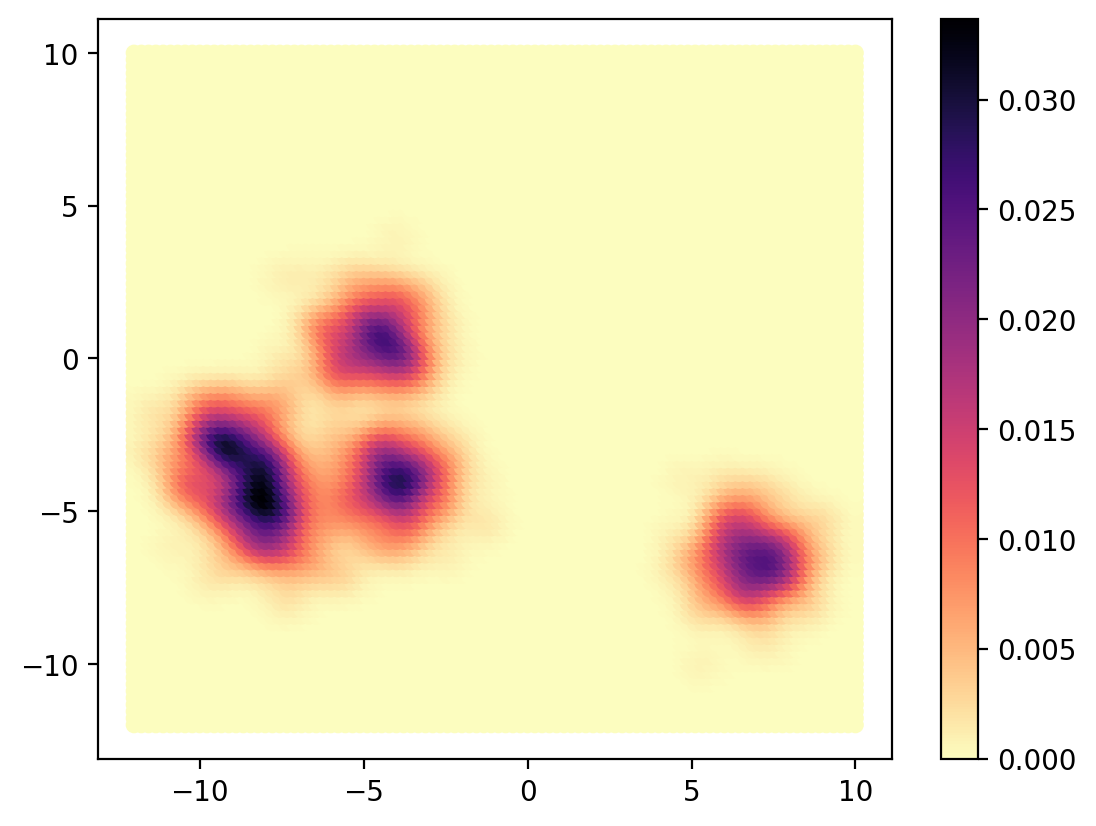

In [ ]:
# Complete and Execute this cell to determine the bandwidth
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

bwrange = np.linspace(0.1, 1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) # Try each bandwidth with K-folds
grid.fit(data[:, :2]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)



kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(data[:, :2]) #fit the model to the data

u = v = np.linspace(-12,10,100)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="magma_r", edgecolor="None")
plt.colorbar()

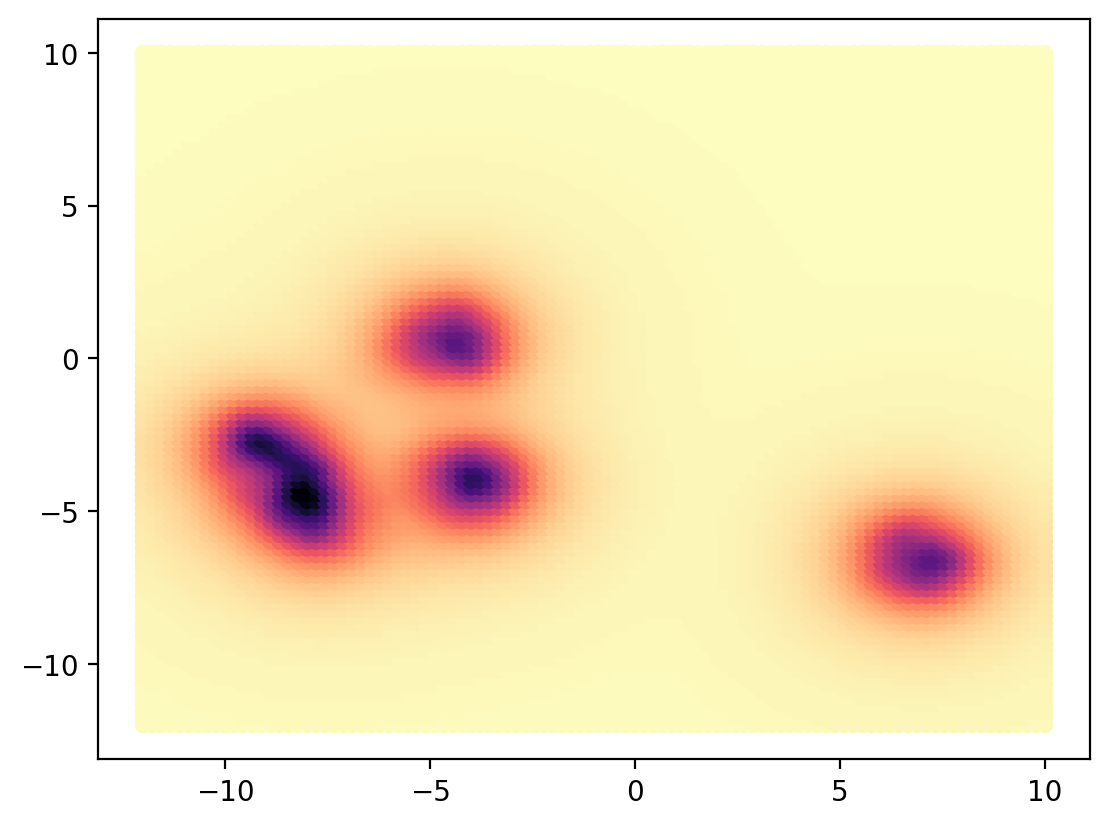

In [ ]:
from astroML.density_estimation import KNeighborsDensity
k = 80 #Number of neighbors
# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(data[:, :2])

u = v = np.linspace(-12,10,100)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
vals = nbrs.eval(Xgrid) 
vals = vals.reshape(100, 100)  # Reshape to match the grid shape

# Plotting

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=vals, 
            cmap="magma_r", edgecolor="None")

#plt.contourf(u, v, vals, cmap='Blues', levels=20)
#plt.scatter(data[:, 0], data[:, 1], c='red', s=5, alpha=0.5)

plt.show()

# K = 100 seems to look like the KDE 



In [ ]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

[10904.59736933538, 9385.432406422336, 8887.245502085483, 8690.168178344935, 8685.38876642369, 8696.169107554824, 8697.426184113556, 8712.10937327531, 8715.698918729873, 8701.965490682545] [10929.136145730292, 9439.41771449114, 8970.67734182818, 8803.046549761524, 8827.713669514173, 8867.940542319198, 8898.644150551823, 8942.773871387471, 8975.809948515925, 8991.523052142491]
4


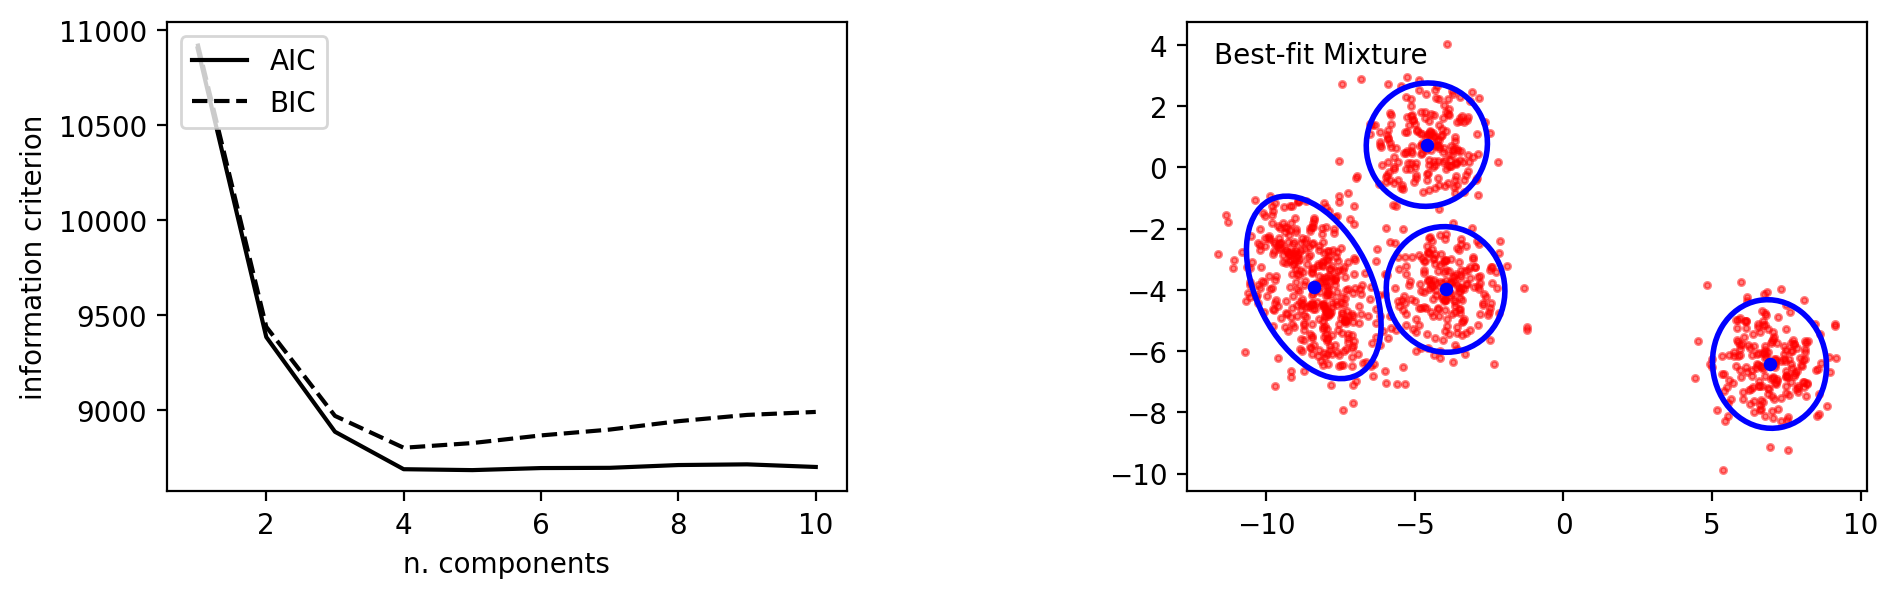

In [ ]:
from sklearn.mixture import GaussianMixture


# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(data[:, :2])

# compute the AIC and the BIC
AIC = [m.aic(data[:, :2]) for m in models]
BIC = [m.bic(data[:, :2]) for m in models]

print(AIC, BIC)

fig = plt.figure(figsize=(10, 3.4))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)



# plot 1: AIC and BIC
ax = fig.add_subplot(121)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 2: Best fit BIC
ax = fig.add_subplot(122)
M_best = N[np.argmin(BIC)]
print(M_best)
best_fit = GaussianMixture(M_best).fit(data[:, :2])
best_fit_means = best_fit.means_
best_fit_covs = best_fit.covariances_

ax.scatter(data[:, 0], data[:, 1], c='red', s=5, alpha=0.5)
ax.scatter(best_fit_means[:, 0], best_fit_means[:, 1], c='blue', s=15, alpha=1)

for i in range(0, len(best_fit_covs)):
    draw_ellipse(best_fit_means[i], best_fit_covs[i], scales=[2], ax=ax, edgecolor='blue', facecolor='none', lw=2)

ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)


plt.show()

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [ ]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

# Compute the KMeans clustering
n_clusters = 5
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(data[:, :2]))

KMeans(n_clusters=5)

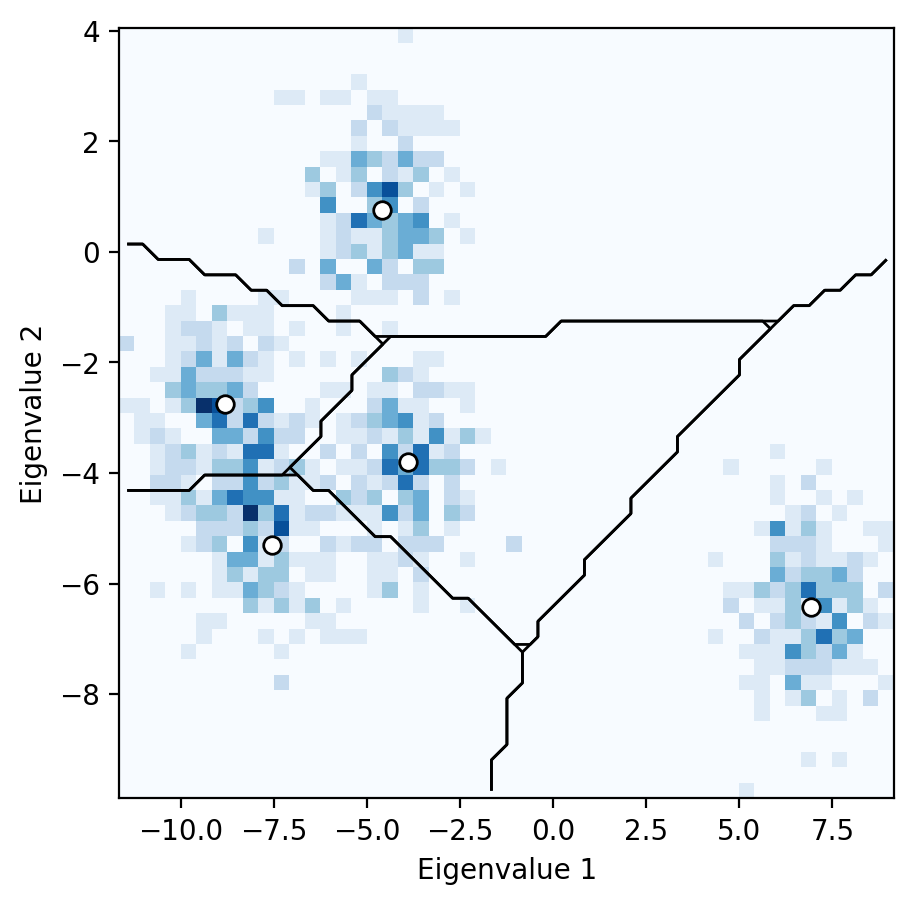

In [ ]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

hist_bins = 50
# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(data[:,0], data[:,1], hist_bins)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, hist_bins * hist_bins)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((hist_bins, hist_bins))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(scaler.transform(Xgrid)).reshape((hist_bins, hist_bins))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')
plt.show()



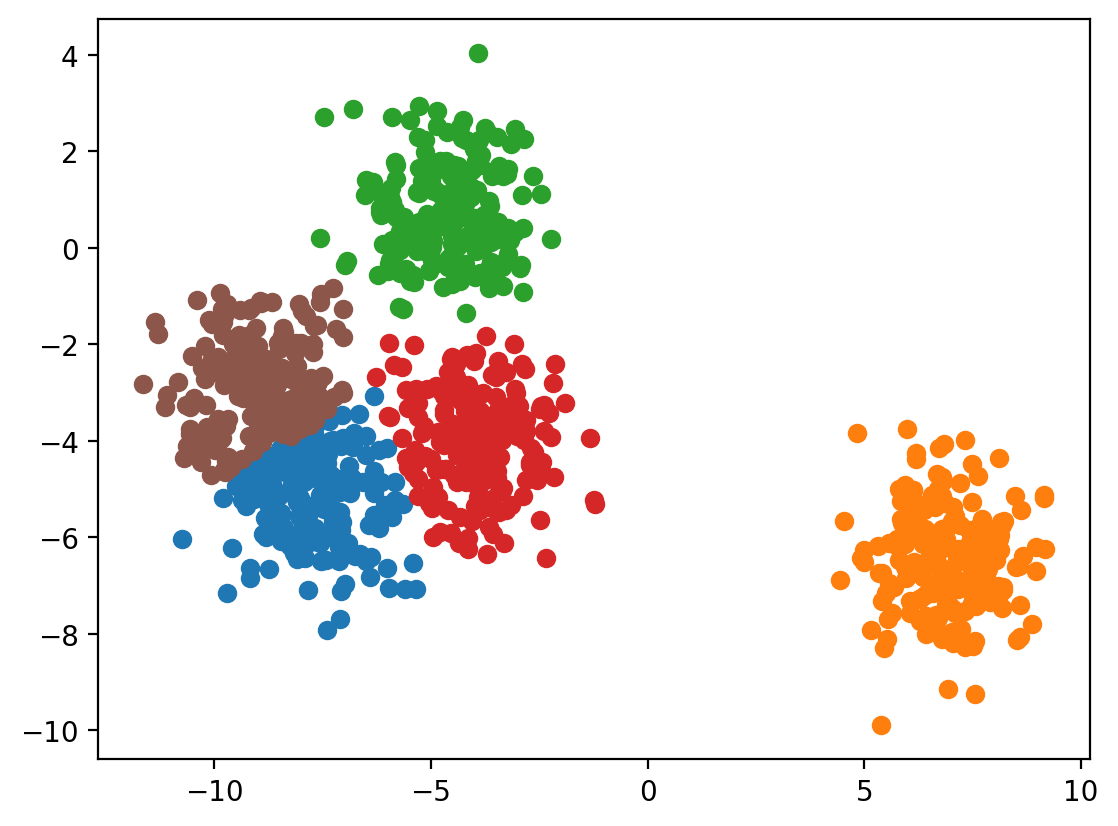

In [ ]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

clf = KMeans(n_clusters=5) #Try 2 clusters to start with
clf.fit(data[:, :2])
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(data[:, :2]) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C0', 'C1', 'C2', 'C3', 'C5']
for ii in range(5):
    plt.scatter(data[labels==ii,0], data[labels==ii,1], 
                color=colors[ii])